In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_excel("Retail_data_final.xlsx")

In [3]:
df

,Date,utility_Michigan,Utility_Texas,Gasoloine_Michigan,Gasoline_Texas,Electricity_michigan,Electricity_texas
0,2000-01-01,0.520,0.571,1.374,1.296,0.097,0.071
1,2000-02-01,0.520,0.571,1.453,1.363,0.097,0.071
2,2000-03-01,0.521,0.604,1.592,1.524,0.097,0.071
3,2000-04-01,0.521,0.604,1.429,1.507,0.097,0.071
4,2000-05-01,0.520,0.604,1.492,1.488,0.097,0.087
...,...,...,...,...,...,...,...
283,2023-08-01,1.121,1.060,3.869,3.477,0.204,0.182
284,2023-09-01,1.144,1.060,3.804,3.396,0.202,0.177
285,2023-10-01,1.159,1.060,3.563,3.170,0.195,0.179
286,2023-11-01,1.169,1.060,3.403,2.888,0.143,0.178


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  288 non-null    datetime64[ns]
 1   utility_Michigan      288 non-null    float64       
 2   Utility_Texas         288 non-null    float64       
 3   Gasoloine_Michigan    288 non-null    float64       
 4   Gasoline_Texas        288 non-null    float64       
 5   Electricity_michigan  288 non-null    float64       
 6   Electricity_texas     288 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 15.9 KB


# Utility

### Michigan

In [5]:
# Select the target column (utility_Michigan in this case)
target_column = 'utility_Michigan'

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[[target_column]])

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Prepare the data for LSTM
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 12  # You can adjust the time steps as needed
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [6]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

Epoch 1/100
7/7 [==============================] - 3s 10ms/step - loss: 0.1917
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0308
Epoch 3/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0208
Epoch 4/100
7/7 [==============================] - 0s 18ms/step - loss: 0.0098
Epoch 5/100
7/7 [==============================] - 0s 18ms/step - loss: 0.0114
Epoch 6/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0079
Epoch 7/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0077
Epoch 8/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0070
Epoch 9/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0068
Epoch 10/100
7/7 [==============================] - 0s 13ms/step - loss: 0.0064
Epoch 11/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0063
Epoch 12/100
7/7 [==============================] - 0s 17ms/step - loss: 0.0062
Epoch 13/100
7/7 [==============================] 

In [7]:
# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

# Calculate accuracy metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)

Train RMSE: 0.04964298615711865
Test RMSE: 0.14234921343764037
Train MAE: 0.03409729342723111
Test MAE: 0.10093720050480053


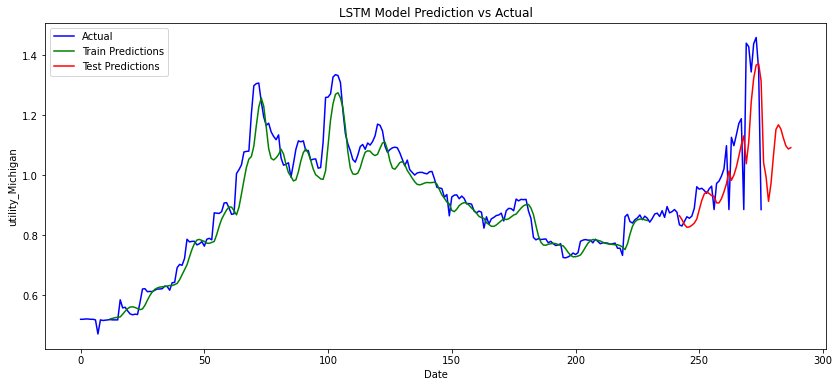

In [8]:
plt.figure(figsize=(14, 6))
plt.plot(df.index[:-time_steps], df[target_column].values[:-time_steps], label='Actual', color='blue')
plt.plot(df.index[time_steps:train_size], train_predictions, label='Train Predictions', color='green')
plt.plot(df.index[train_size + time_steps:], test_predictions, label='Test Predictions', color='red')
plt.title('LSTM Model Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel(target_column)
plt.legend()
plt.show()


In [9]:
print(df.columns)


Index(['Date', 'utility_Michigan', 'Utility_Texas', 'Gasoloine_Michigan',
       'Gasoline_Texas', 'Electricity_michigan', 'Electricity_texas'],
      dtype='object')


In [10]:
# Prepare the features for the next time period
X_next_period = df[target_column].iloc[-time_steps:].values.reshape(1, time_steps, 1)

# Reshape the features for scaling
X_next_period_reshaped = X_next_period.reshape(-1, 1)

# Scale the features for the next time period
X_next_period_scaled = scaler.transform(X_next_period_reshaped)

# Reshape the scaled features for LSTM input
X_next_period_scaled_reshaped = X_next_period_scaled.reshape(1, time_steps, 1)

try:
    # Use the trained LSTM model to predict the target variable for the next time period
    predicted_values = model.predict(X_next_period_scaled_reshaped)
    
    # Inverse transform the predicted values to get the actual values
    predicted_values_actual = scaler.inverse_transform(predicted_values)
    
    print("Predicted values for the next time period:")
    print(predicted_values_actual)
except Exception as e:
    print("Error occurred during prediction:", e)


1/1 [==============================] - 0s 26ms/step
Predicted values for the next time period:
[[1.116079]]


C:\Users\riyab\anaconda3\anaconda\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [11]:
# Assuming you have already trained your LSTM model and defined 'model' variable

import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names, but MinMaxScaler was fitted with feature names")

# Define the number of future time periods to predict
num_periods = 48  # Adjust this according to your requirement

# Initialize a list to store the predicted values for each future time period
predicted_values_all = []

# Loop over the number of future time periods to predict
for _ in range(num_periods):
    # Prepare the features for the next time period
    X_next_period = df[target_column].values[-time_steps:].reshape(1, -1)
    
    # Reshape the features for scaling
    X_next_period_reshaped = X_next_period.reshape(-1, 1)
    
    # Scale the features for the next time period
    X_next_period_scaled = scaler.transform(X_next_period_reshaped)
    
    # Reshape the scaled features for LSTM input
    X_next_period_scaled_reshaped = X_next_period_scaled.reshape(1, time_steps, 1)
    
    # Use the trained LSTM model to predict the target variable for the next time period
    predicted_values = model.predict(X_next_period_scaled_reshaped)
    
    # Inverse transform the predicted values to get the actual values
    predicted_values_actual = scaler.inverse_transform(predicted_values)
    
    # Append the predicted value to the list
    predicted_values_all.append(predicted_values_actual[0][0])
    
    # Update the input data for the next iteration (shift the time steps by 1)
    df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)

print("Predicted values for the next", num_periods, "time periods:")
print(predicted_values_all)





1/1 [==============================] - 0s 32ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 16ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 32ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 33ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 33ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 32ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 16ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 16ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 34ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 32ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 27ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 19ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - ETA: 0s

C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 16ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - ETA: 0s

C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 16ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 16ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 31ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 21ms/step
Predicted values for the next 48 time periods:
[1.116079, 1.0919559, 1.0744896, 1.0391196, 1.0069662, 0.9788721, 0.9552813, 0.9356372, 0.92025787, 0.90687436, 0.89494085, 0.88369495, 0.8728351, 0.8633778, 0.85425955, 0.84531724, 0.8370303, 0.82934296, 0.8222346, 0.8156902, 0.8096941, 0.80420727, 0.7992025, 0.7946457, 0.79050446, 0.78674746, 0.7833334, 0.7802315, 0.7774143, 0.77485377, 0.77252436, 0.77040297, 0.7684688, 0.7667027, 0.76508796, 0.76360923, 0.76225305, 0.76100737, 0.75986123, 0.7588051, 0.75783056, 0.75692976, 0.7560961, 0.7553234, 0.7546064, 0.75394017, 0.75332034, 0.7527431]


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


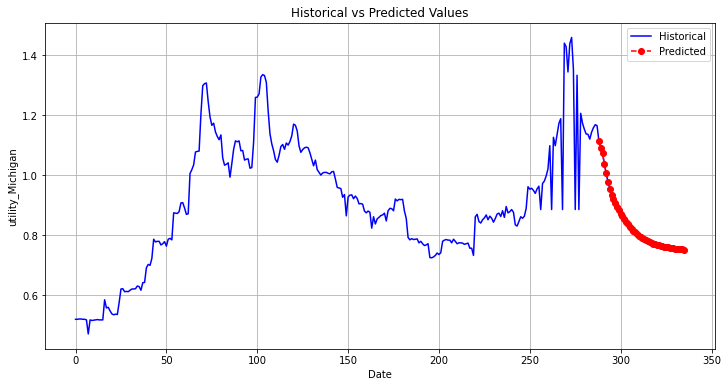

In [12]:
import matplotlib.pyplot as plt

# Extracting the historical data and dates
historical_dates = df.index.tolist()
historical_values = df[target_column].values.tolist()

# Plotting the historical and predicted values
plt.figure(figsize=(12, 6))
plt.plot(historical_dates, historical_values, label='Historical', color='blue')
plt.plot(historical_dates[-len(predicted_values_all):], predicted_values_all, label='Predicted', color='red', linestyle='--', marker='o')
plt.title('Historical vs Predicted Values')
plt.xlabel('Date')
plt.ylabel(target_column)
plt.legend()
plt.grid(True)
plt.show()


In [13]:
df.head()

,Date,utility_Michigan,Utility_Texas,Gasoloine_Michigan,Gasoline_Texas,Electricity_michigan,Electricity_texas
0,2000-01-01 00:00:00,0.520,0.571,1.374,1.296,0.097,0.071
1,2000-02-01 00:00:00,0.520,0.571,1.453,1.363,0.097,0.071
2,2000-03-01 00:00:00,0.521,0.604,1.592,1.524,0.097,0.071
3,2000-04-01 00:00:00,0.521,0.604,1.429,1.507,0.097,0.071
4,2000-05-01 00:00:00,0.520,0.604,1.492,1.488,0.097,0.087


### Texas

In [14]:
df = pd.read_excel("Retail_data_final.xlsx")

In [15]:
# Select the target column (utility_Michigan in this case)
target_column = 'Utility_Texas'

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[[target_column]])

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Prepare the data for LSTM
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 12  # You can adjust the time steps as needed
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [16]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

Epoch 1/100
7/7 [==============================] - 3s 12ms/step - loss: 0.0551
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0196
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0113
Epoch 4/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0118
Epoch 5/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0089
Epoch 6/100
7/7 [==============================] - 0s 11ms/step - loss: 0.0094
Epoch 7/100
7/7 [==============================] - 0s 11ms/step - loss: 0.0088
Epoch 8/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0089
Epoch 9/100
7/7 [==============================] - 0s 11ms/step - loss: 0.0087
Epoch 10/100
7/7 [==============================] - 0s 11ms/step - loss: 0.0087
Epoch 11/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0085
Epoch 12/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0084
Epoch 13/100
7/7 [==============================] - 0s 1

In [17]:
# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

# Calculate accuracy metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)

Train RMSE: 0.07188258015108517
Test RMSE: 0.177622002059169
Train MAE: 0.041437855333363235
Test MAE: 0.0973382824918498


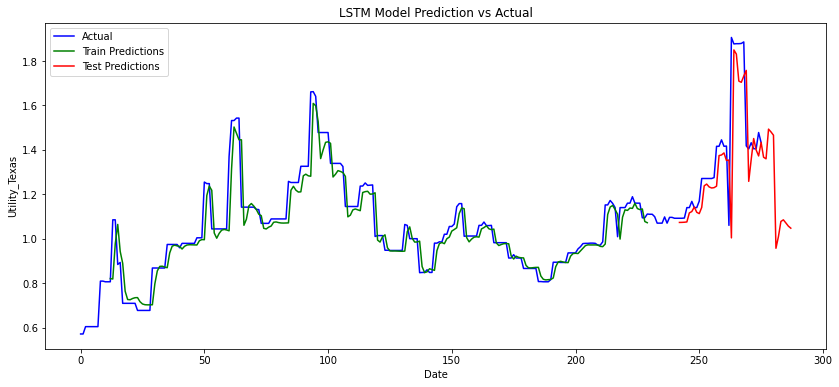

In [18]:
plt.figure(figsize=(14, 6))
plt.plot(df.index[:-time_steps], df[target_column].values[:-time_steps], label='Actual', color='blue')
plt.plot(df.index[time_steps:train_size], train_predictions, label='Train Predictions', color='green')
plt.plot(df.index[train_size + time_steps:], test_predictions, label='Test Predictions', color='red')
plt.title('LSTM Model Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel(target_column)
plt.legend()
plt.show()


In [19]:
# Prepare the features for the next time period
X_next_period = df[target_column].iloc[-time_steps:].values.reshape(1, time_steps, 1)

# Reshape the features for scaling
X_next_period_reshaped = X_next_period.reshape(-1, 1)

# Scale the features for the next time period
X_next_period_scaled = scaler.transform(X_next_period_reshaped)

# Reshape the scaled features for LSTM input
X_next_period_scaled_reshaped = X_next_period_scaled.reshape(1, time_steps, 1)

try:
    # Use the trained LSTM model to predict the target variable for the next time period
    predicted_values = model.predict(X_next_period_scaled_reshaped)
    
    # Inverse transform the predicted values to get the actual values
    predicted_values_actual = scaler.inverse_transform(predicted_values)
    
    print("Predicted values for the next time period:")
    print(predicted_values_actual)
except Exception as e:
    print("Error occurred during prediction:", e)


1/1 [==============================] - 0s 16ms/step
Predicted values for the next time period:
[[1.0417094]]


In [20]:
# Assuming you have already trained your LSTM model and defined 'model' variable

import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names, but MinMaxScaler was fitted with feature names")

# Define the number of future time periods to predict
num_periods = 48  # Adjust this according to your requirement

# Initialize a list to store the predicted values for each future time period
predicted_values_all = []

# Loop over the number of future time periods to predict
for _ in range(num_periods):
    # Prepare the features for the next time period
    X_next_period = df[target_column].values[-time_steps:].reshape(1, -1)
    
    # Reshape the features for scaling
    X_next_period_reshaped = X_next_period.reshape(-1, 1)
    
    # Scale the features for the next time period
    X_next_period_scaled = scaler.transform(X_next_period_reshaped)
    
    # Reshape the scaled features for LSTM input
    X_next_period_scaled_reshaped = X_next_period_scaled.reshape(1, time_steps, 1)
    
    # Use the trained LSTM model to predict the target variable for the next time period
    predicted_values = model.predict(X_next_period_scaled_reshaped)
    
    # Inverse transform the predicted values to get the actual values
    predicted_values_actual = scaler.inverse_transform(predicted_values)
    
    # Append the predicted value to the list
    predicted_values_all.append(predicted_values_actual[0][0])
    
    # Update the input data for the next iteration (shift the time steps by 1)
    df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)

print("Predicted values for the next", num_periods, "time periods:")
print(predicted_values_all)





1/1 [==============================] - 0s 20ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 49ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 34ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 20ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 18ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 32ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - ETA: 0s

C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - ETA: 0s

C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 17ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 32ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 16ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 34ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 8ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 33ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 33ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 34ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 33ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 17ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 49ms/step
Predicted values for the next 48 time periods:
[1.0417094, 1.0233362, 1.0065958, 0.99393034, 0.98587817, 0.9792604, 0.9740067, 0.96935564, 0.9649086, 0.96051174, 0.9561823, 0.95202833, 0.9481799, 0.9446565, 0.9414577, 0.93855226, 0.9359019, 0.9334746, 0.93124044, 0.9291777, 0.92727095, 0.9255079, 0.92387885, 0.9223742, 0.9209853, 0.91970336, 0.9185202, 0.9174281, 0.9164197, 0.91548836, 0.91462797, 0.91383326, 0.9130987, 0.9124202, 0.9117932, 0.91121364, 0.91067815, 0.9101832, 0.90972584, 0.90930295, 0.9089121, 0.9085508, 0.90821683, 0.9079081, 0.90762264, 0.9073587, 0.9071148, 0.9068893]


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


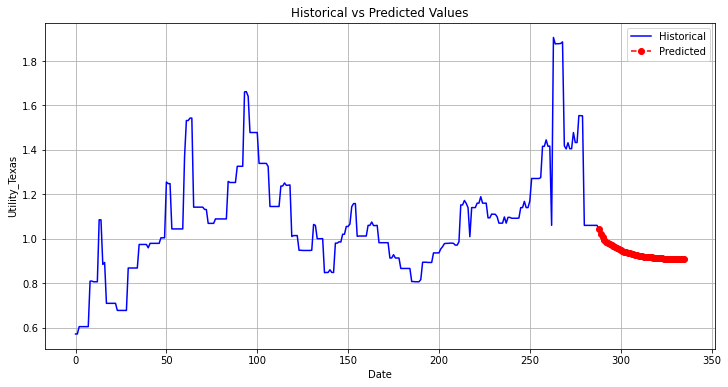

In [21]:
import matplotlib.pyplot as plt

# Extracting the historical data and dates
historical_dates = df.index.tolist()
historical_values = df[target_column].values.tolist()

# Plotting the historical and predicted values
plt.figure(figsize=(12, 6))
plt.plot(historical_dates, historical_values, label='Historical', color='blue')
plt.plot(historical_dates[-len(predicted_values_all):], predicted_values_all, label='Predicted', color='red', linestyle='--', marker='o')
plt.title('Historical vs Predicted Values')
plt.xlabel('Date')
plt.ylabel(target_column)
plt.legend()
plt.grid(True)
plt.show()


# Gasoloine

### Michigan

In [22]:
df = pd.read_excel("Retail_data_final.xlsx")

In [23]:
# Select the target column (utility_Michigan in this case)
target_column = 'Gasoloine_Michigan'

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[[target_column]])

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Prepare the data for LSTM
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 12  # You can adjust the time steps as needed
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [24]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

Epoch 1/100
7/7 [==============================] - 4s 12ms/step - loss: 0.1017
Epoch 2/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0219
Epoch 3/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0156
Epoch 4/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0160
Epoch 5/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0133
Epoch 6/100
7/7 [==============================] - 0s 11ms/step - loss: 0.0131
Epoch 7/100
7/7 [==============================] - 0s 13ms/step - loss: 0.0115
Epoch 8/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0117
Epoch 9/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0112
Epoch 10/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0112
Epoch 11/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0111
Epoch 12/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0109
Epoch 13/100
7/7 [==============================]

In [25]:
# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

# Calculate accuracy metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)

Train RMSE: 0.22450171570041766
Test RMSE: 0.37204304610444977
Train MAE: 0.17254682712379943
Test MAE: 0.29115497916677713


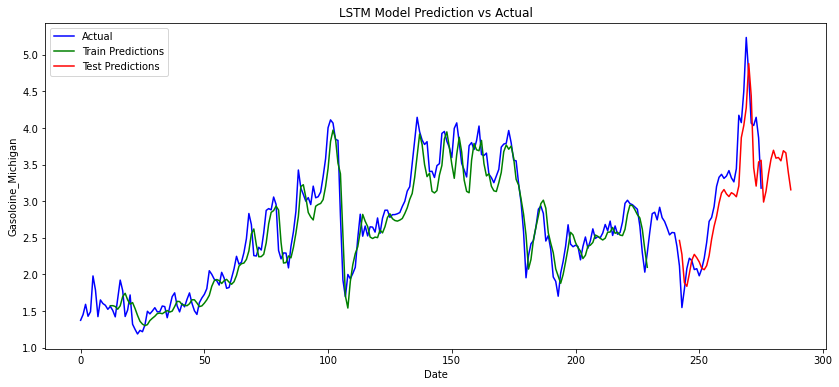

In [26]:
plt.figure(figsize=(14, 6))
plt.plot(df.index[:-time_steps], df[target_column].values[:-time_steps], label='Actual', color='blue')
plt.plot(df.index[time_steps:train_size], train_predictions, label='Train Predictions', color='green')
plt.plot(df.index[train_size + time_steps:], test_predictions, label='Test Predictions', color='red')
plt.title('LSTM Model Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel(target_column)
plt.legend()
plt.show()


In [27]:
# Prepare the features for the next time period
X_next_period = df[target_column].iloc[-time_steps:].values.reshape(1, time_steps, 1)

# Reshape the features for scaling
X_next_period_reshaped = X_next_period.reshape(-1, 1)

# Scale the features for the next time period
X_next_period_scaled = scaler.transform(X_next_period_reshaped)

# Reshape the scaled features for LSTM input
X_next_period_scaled_reshaped = X_next_period_scaled.reshape(1, time_steps, 1)

try:
    # Use the trained LSTM model to predict the target variable for the next time period
    predicted_values = model.predict(X_next_period_scaled_reshaped)
    
    # Inverse transform the predicted values to get the actual values
    predicted_values_actual = scaler.inverse_transform(predicted_values)
    
    print("Predicted values for the next time period:")
    print(predicted_values_actual)
except Exception as e:
    print("Error occurred during prediction:", e)


1/1 [==============================] - 0s 20ms/step
Predicted values for the next time period:
[[2.9272342]]


In [28]:
# Assuming you have already trained your LSTM model and defined 'model' variable

import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names, but MinMaxScaler was fitted with feature names")

# Define the number of future time periods to predict
num_periods = 48  # Adjust this according to your requirement

# Initialize a list to store the predicted values for each future time period
predicted_values_all = []

# Loop over the number of future time periods to predict
for _ in range(num_periods):
    # Prepare the features for the next time period
    X_next_period = df[target_column].values[-time_steps:].reshape(1, -1)
    
    # Reshape the features for scaling
    X_next_period_reshaped = X_next_period.reshape(-1, 1)
    
    # Scale the features for the next time period
    X_next_period_scaled = scaler.transform(X_next_period_reshaped)
    
    # Reshape the scaled features for LSTM input
    X_next_period_scaled_reshaped = X_next_period_scaled.reshape(1, time_steps, 1)
    
    # Use the trained LSTM model to predict the target variable for the next time period
    predicted_values = model.predict(X_next_period_scaled_reshaped)
    
    # Inverse transform the predicted values to get the actual values
    predicted_values_actual = scaler.inverse_transform(predicted_values)
    
    # Append the predicted value to the list
    predicted_values_all.append(predicted_values_actual[0][0])
    
    # Update the input data for the next iteration (shift the time steps by 1)
    df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)

print("Predicted values for the next", num_periods, "time periods:")
print(predicted_values_all)





1/1 [==============================] - 0s 20ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 21ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 29ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 20ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 12ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 33ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 33ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 33ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 33ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - ETA: 0s

C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 27ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - ETA: 0s

C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - ETA: 0s

C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 16ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 16ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - ETA: 0s

C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - ETA: 0s

C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 25ms/step
Predicted values for the next 48 time periods:
[2.9272342, 2.7728407, 2.699178, 2.6980243, 2.7497294, 2.8333533, 2.923115, 3.000567, 3.0444849, 3.0474296, 3.0107603, 2.9394865, 2.8491056, 2.7558918, 2.6762104, 2.6211095, 2.5944107, 2.5931675, 2.6099293, 2.635489, 2.66093, 2.6792598, 2.6861541, 2.6802022, 2.6627414, 2.6371005, 2.6077216, 2.5791051, 2.5548854, 2.5372083, 2.5265498, 2.5219562, 2.5215425, 2.5230756, 2.5244813, 2.5242038, 2.521385, 2.5158718, 2.5080998, 2.4988842, 2.4891884, 2.4799054, 2.4716947, 2.4649036, 2.4595644, 2.4554558, 2.4522011, 2.4493759]


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


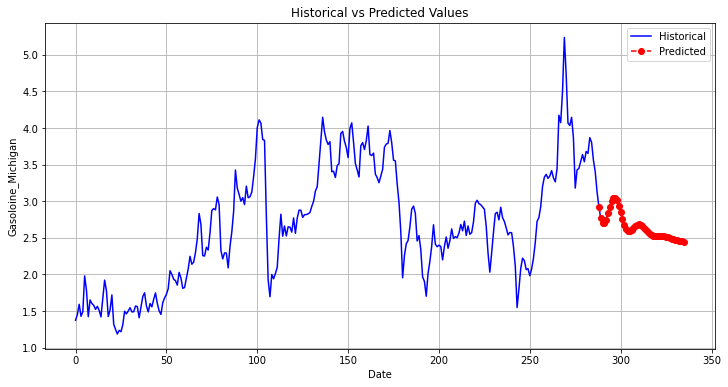

In [29]:
import matplotlib.pyplot as plt

# Extracting the historical data and dates
historical_dates = df.index.tolist()
historical_values = df[target_column].values.tolist()

# Plotting the historical and predicted values
plt.figure(figsize=(12, 6))
plt.plot(historical_dates, historical_values, label='Historical', color='blue')
plt.plot(historical_dates[-len(predicted_values_all):], predicted_values_all, label='Predicted', color='red', linestyle='--', marker='o')
plt.title('Historical vs Predicted Values')
plt.xlabel('Date')
plt.ylabel(target_column)
plt.legend()
plt.grid(True)
plt.show()


### Texas

In [30]:
df = pd.read_excel("Retail_data_final.xlsx")

In [31]:
# Select the target column (utility_Michigan in this case)
target_column = 'Gasoline_Texas'

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[[target_column]])

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Prepare the data for LSTM
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 12  # You can adjust the time steps as needed
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [32]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

Epoch 1/100
7/7 [==============================] - 3s 11ms/step - loss: 0.1201
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0245
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0192
Epoch 4/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0180
Epoch 5/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0152
Epoch 6/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0148
Epoch 7/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0134
Epoch 8/100
7/7 [==============================] - 0s 13ms/step - loss: 0.0137
Epoch 9/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0133
Epoch 10/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0130
Epoch 11/100
7/7 [==============================] - 0s 13ms/step - loss: 0.0130
Epoch 12/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0125
Epoch 13/100
7/7 [==============================] -

In [33]:
# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

# Calculate accuracy metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)

Train RMSE: 0.20215586876385574
Test RMSE: 0.29831059562867795
Train MAE: 0.15525766812333278
Test MAE: 0.22746104134684025


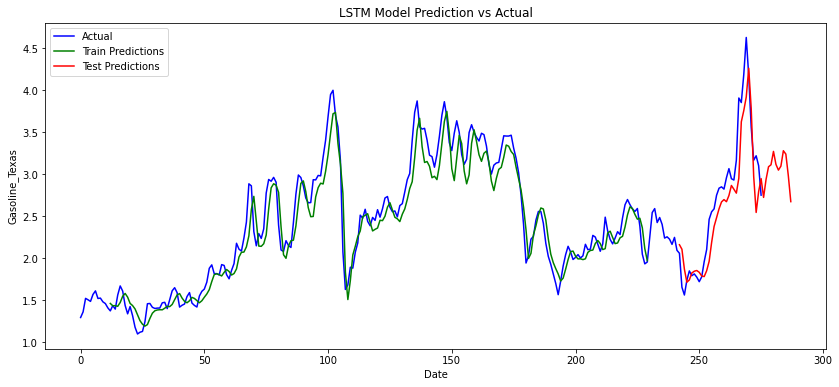

In [34]:
plt.figure(figsize=(14, 6))
plt.plot(df.index[:-time_steps], df[target_column].values[:-time_steps], label='Actual', color='blue')
plt.plot(df.index[time_steps:train_size], train_predictions, label='Train Predictions', color='green')
plt.plot(df.index[train_size + time_steps:], test_predictions, label='Test Predictions', color='red')
plt.title('LSTM Model Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel(target_column)
plt.legend()
plt.show()


In [35]:
# Prepare the features for the next time period
X_next_period = df[target_column].iloc[-time_steps:].values.reshape(1, time_steps, 1)

# Reshape the features for scaling
X_next_period_reshaped = X_next_period.reshape(-1, 1)

# Scale the features for the next time period
X_next_period_scaled = scaler.transform(X_next_period_reshaped)

# Reshape the scaled features for LSTM input
X_next_period_scaled_reshaped = X_next_period_scaled.reshape(1, time_steps, 1)

try:
    # Use the trained LSTM model to predict the target variable for the next time period
    predicted_values = model.predict(X_next_period_scaled_reshaped)
    
    # Inverse transform the predicted values to get the actual values
    predicted_values_actual = scaler.inverse_transform(predicted_values)
    
    print("Predicted values for the next time period:")
    print(predicted_values_actual)
except Exception as e:
    print("Error occurred during prediction:", e)


1/1 [==============================] - 0s 35ms/step
Predicted values for the next time period:
[[2.517534]]


In [36]:
# Assuming you have already trained your LSTM model and defined 'model' variable

import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names, but MinMaxScaler was fitted with feature names")

# Define the number of future time periods to predict
num_periods = 48  

# Initialize a list to store the predicted values for each future time period
predicted_values_all = []

# Loop over the number of future time periods to predict
for _ in range(num_periods):
    # Prepare the features for the next time period
    X_next_period = df[target_column].values[-time_steps:].reshape(1, -1)
    
    # Reshape the features for scaling
    X_next_period_reshaped = X_next_period.reshape(-1, 1)
    
    # Scale the features for the next time period
    X_next_period_scaled = scaler.transform(X_next_period_reshaped)
    
    # Reshape the scaled features for LSTM input
    X_next_period_scaled_reshaped = X_next_period_scaled.reshape(1, time_steps, 1)
    
    # Use the trained LSTM model to predict the target variable for the next time period
    predicted_values = model.predict(X_next_period_scaled_reshaped)
    
    # Inverse transform the predicted values to get the actual values
    predicted_values_actual = scaler.inverse_transform(predicted_values)
    
    # Append the predicted value to the list
    predicted_values_all.append(predicted_values_actual[0][0])
    
    # Update the input data for the next iteration (shift the time steps by 1)
    df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)

print("Predicted values for the next", num_periods, "time periods:")
print(predicted_values_all)





1/1 [==============================] - 0s 34ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 30ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - ETA: 0s

C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - ETA: 0s

C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 34ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 33ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 33ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - ETA: 0s

C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 33ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 33ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 33ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 33ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 17ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 17ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - ETA: 0s

C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 33ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 21ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 19ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 16ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 19ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 22ms/step
Predicted values for the next 48 time periods:
[2.517534, 2.419628, 2.394302, 2.4211216, 2.4710224, 2.5258355, 2.568848, 2.5905921, 2.585605, 2.5577617, 2.5142035, 2.4637978, 2.4140515, 2.3720605, 2.3411531, 2.3215878, 2.3111746, 2.3065703, 2.3043227, 2.301667, 2.2968645, 2.2892592, 2.2790432, 2.266961, 2.2539952, 2.2411067, 2.2290292, 2.2181811, 2.208671, 2.2003632, 2.19298, 2.1862018, 2.1797435, 2.1734, 2.1670587, 2.1606915, 2.154329, 2.148035, 2.1418793, 2.1359193, 2.1301908, 2.1247067, 2.1194582, 2.1144254, 2.1095803, 2.1048975, 2.1003537, 2.095934]


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\2330509836.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


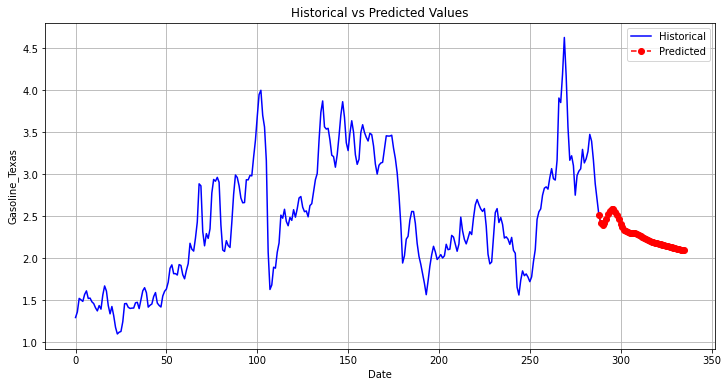

In [37]:
import matplotlib.pyplot as plt

# Extracting the historical data and dates
historical_dates = df.index.tolist()
historical_values = df[target_column].values.tolist()

# Plotting the historical and predicted values
plt.figure(figsize=(12, 6))
plt.plot(historical_dates, historical_values, label='Historical', color='blue')
plt.plot(historical_dates[-len(predicted_values_all):], predicted_values_all, label='Predicted', color='red', linestyle='--', marker='o')
plt.title('Historical vs Predicted Values')
plt.xlabel('Date')
plt.ylabel(target_column)
plt.legend()
plt.grid(True)
plt.show()


# Electricity

### michigan

In [38]:
df = pd.read_excel("Retail_data_final.xlsx")

In [39]:
# Select the target column (utility_Michigan in this case)
target_column = 'Electricity_michigan'

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[[target_column]])

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Prepare the data for LSTM
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 12  # You can adjust the time steps as needed
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [40]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

Epoch 1/100
7/7 [==============================] - 4s 11ms/step - loss: 0.0816
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0157
Epoch 3/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0076
Epoch 4/100
7/7 [==============================] - 0s 17ms/step - loss: 0.0074
Epoch 5/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0036
Epoch 6/100
7/7 [==============================] - 0s 13ms/step - loss: 0.0035
Epoch 7/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0033
Epoch 8/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0030
Epoch 9/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0030
Epoch 10/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0030
Epoch 11/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0028
Epoch 12/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0028
Epoch 13/100
7/7 [==============================]

In [41]:
# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

# Calculate accuracy metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)

Train RMSE: 0.005186554430083715
Test RMSE: 0.014527783574136881
Train MAE: 0.0038569746077607545
Test MAE: 0.0122830999130788


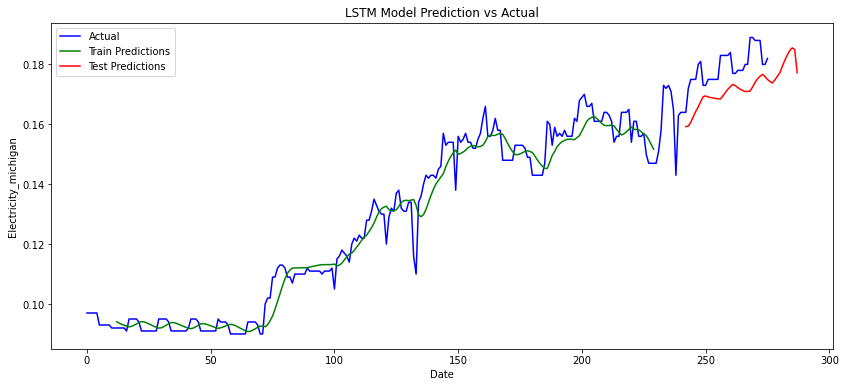

In [42]:
plt.figure(figsize=(14, 6))
plt.plot(df.index[:-time_steps], df[target_column].values[:-time_steps], label='Actual', color='blue')
plt.plot(df.index[time_steps:train_size], train_predictions, label='Train Predictions', color='green')
plt.plot(df.index[train_size + time_steps:], test_predictions, label='Test Predictions', color='red')
plt.title('LSTM Model Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel(target_column)
plt.legend()
plt.show()


In [43]:
# Prepare the features for the next time period
X_next_period = df[target_column].iloc[-time_steps:].values.reshape(1, time_steps, 1)

# Reshape the features for scaling
X_next_period_reshaped = X_next_period.reshape(-1, 1)

# Scale the features for the next time period
X_next_period_scaled = scaler.transform(X_next_period_reshaped)

# Reshape the scaled features for LSTM input
X_next_period_scaled_reshaped = X_next_period_scaled.reshape(1, time_steps, 1)

try:
    # Use the trained LSTM model to predict the target variable for the next time period
    predicted_values = model.predict(X_next_period_scaled_reshaped)
    
    # Inverse transform the predicted values to get the actual values
    predicted_values_actual = scaler.inverse_transform(predicted_values)
    
    print("Predicted values for the next time period:")
    print(predicted_values_actual)
except Exception as e:
    print("Error occurred during prediction:", e)


1/1 [==============================] - 0s 32ms/step
Predicted values for the next time period:
[[0.16913453]]


In [44]:
# Assuming you have already trained your LSTM model and defined 'model' variable

import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names, but MinMaxScaler was fitted with feature names")

# Define the number of future time periods to predict
num_periods = 48  # Adjust this according to your requirement

# Initialize a list to store the predicted values for each future time period
predicted_values_all = []

# Loop over the number of future time periods to predict
for _ in range(num_periods):
    # Prepare the features for the next time period
    X_next_period = df[target_column].values[-time_steps:].reshape(1, -1)
    
    # Reshape the features for scaling
    X_next_period_reshaped = X_next_period.reshape(-1, 1)
    
    # Scale the features for the next time period
    X_next_period_scaled = scaler.transform(X_next_period_reshaped)
    
    # Reshape the scaled features for LSTM input
    X_next_period_scaled_reshaped = X_next_period_scaled.reshape(1, time_steps, 1)
    
    # Use the trained LSTM model to predict the target variable for the next time period
    predicted_values = model.predict(X_next_period_scaled_reshaped)
    
    # Inverse transform the predicted values to get the actual values
    predicted_values_actual = scaler.inverse_transform(predicted_values)
    
    # Append the predicted value to the list
    predicted_values_all.append(predicted_values_actual[0][0])
    
    # Update the input data for the next iteration (shift the time steps by 1)
    df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)

print("Predicted values for the next", num_periods, "time periods:")
print(predicted_values_all)





1/1 [==============================] - ETA: 0s

C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 17ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 17ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 17ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - ETA: 0s

C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 33ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 33ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 32ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 33ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - ETA: 0s

C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 18ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 34ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - ETA: 0s

C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 30ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 13ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 21ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - ETA: 0s

C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 16ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - ETA: 0s

C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 34ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 50ms/step
Predicted values for the next 48 time periods:
[0.16913453, 0.16544111, 0.16303979, 0.16137278, 0.16014323, 0.1592272, 0.15849437, 0.157892, 0.15738665, 0.15694176, 0.15652831, 0.15604573, 0.15556845, 0.15516661, 0.1547936, 0.15444465, 0.15411687, 0.1538084, 0.15351792, 0.15324433, 0.15298662, 0.15274388, 0.1525152, 0.15229969, 0.1520964, 0.15190448, 0.15172318, 0.15155186, 0.15138988, 0.1512367, 0.15109178, 0.15095463, 0.15082479, 0.15070179, 0.15058528, 0.15047488, 0.15037021, 0.15027097, 0.15017684, 0.15008757, 0.15000287, 0.14992246, 0.14984615, 0.14977372, 0.14970492, 0.14963958, 0.14957753, 0.14951858]


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


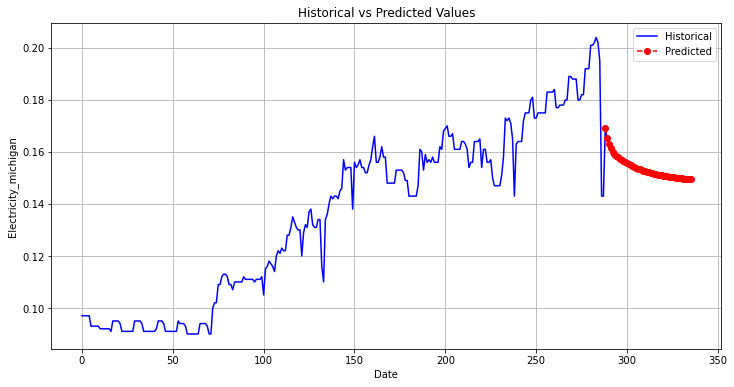

In [45]:
import matplotlib.pyplot as plt

# Extracting the historical data and dates
historical_dates = df.index.tolist()
historical_values = df[target_column].values.tolist()

# Plotting the historical and predicted values
plt.figure(figsize=(12, 6))
plt.plot(historical_dates, historical_values, label='Historical', color='blue')
plt.plot(historical_dates[-len(predicted_values_all):], predicted_values_all, label='Predicted', color='red', linestyle='--', marker='o')
plt.title('Historical vs Predicted Values')
plt.xlabel('Date')
plt.ylabel(target_column)
plt.legend()
plt.grid(True)
plt.show()


### Texas

In [46]:
df = pd.read_excel("Retail_data_final.xlsx")

In [47]:
# Select the target column (utility_Michigan in this case)
target_column = 'Electricity_texas'

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[[target_column]])

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Prepare the data for LSTM
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 12  # You can adjust the time steps as needed
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [48]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

Epoch 1/100
7/7 [==============================] - 3s 14ms/step - loss: 0.0487
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0118
Epoch 3/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0062
Epoch 4/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0076
Epoch 5/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0053
Epoch 6/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0056
Epoch 7/100
7/7 [==============================] - 0s 17ms/step - loss: 0.0050
Epoch 8/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0050
Epoch 9/100
7/7 [==============================] - 0s 17ms/step - loss: 0.0048
Epoch 10/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0046
Epoch 11/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0047
Epoch 12/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0047
Epoch 13/100
7/7 [==============================] 

In [49]:
# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

# Calculate accuracy metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)

Train RMSE: 0.007647907180828787
Test RMSE: 0.02466913586059487
Train MAE: 0.00528881277157626
Test MAE: 0.014861096896555112


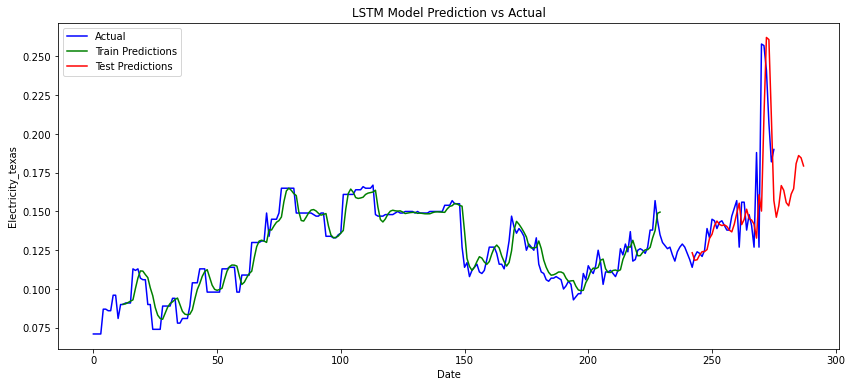

In [50]:
plt.figure(figsize=(14, 6))
plt.plot(df.index[:-time_steps], df[target_column].values[:-time_steps], label='Actual', color='blue')
plt.plot(df.index[time_steps:train_size], train_predictions, label='Train Predictions', color='green')
plt.plot(df.index[train_size + time_steps:], test_predictions, label='Test Predictions', color='red')
plt.title('LSTM Model Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel(target_column)
plt.legend()
plt.show()


In [51]:
# Prepare the features for the next time period
X_next_period = df[target_column].iloc[-time_steps:].values.reshape(1, time_steps, 1)

# Reshape the features for scaling
X_next_period_reshaped = X_next_period.reshape(-1, 1)

# Scale the features for the next time period
X_next_period_scaled = scaler.transform(X_next_period_reshaped)

# Reshape the scaled features for LSTM input
X_next_period_scaled_reshaped = X_next_period_scaled.reshape(1, time_steps, 1)

try:
    # Use the trained LSTM model to predict the target variable for the next time period
    predicted_values = model.predict(X_next_period_scaled_reshaped)
    
    # Inverse transform the predicted values to get the actual values
    predicted_values_actual = scaler.inverse_transform(predicted_values)
    
    print("Predicted values for the next time period:")
    print(predicted_values_actual)
except Exception as e:
    print("Error occurred during prediction:", e)


1/1 [==============================] - 0s 30ms/step
Predicted values for the next time period:
[[0.17419197]]


In [52]:
# Assuming you have already trained your LSTM model and defined 'model' variable

import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names, but MinMaxScaler was fitted with feature names")

# Define the number of future time periods to predict
num_periods = 48  # Adjust this according to your requirement

# Initialize a list to store the predicted values for each future time period
predicted_values_all = []

# Loop over the number of future time periods to predict
for _ in range(num_periods):
    # Prepare the features for the next time period
    X_next_period = df[target_column].values[-time_steps:].reshape(1, -1)
    
    # Reshape the features for scaling
    X_next_period_reshaped = X_next_period.reshape(-1, 1)
    
    # Scale the features for the next time period
    X_next_period_scaled = scaler.transform(X_next_period_reshaped)
    
    # Reshape the scaled features for LSTM input
    X_next_period_scaled_reshaped = X_next_period_scaled.reshape(1, time_steps, 1)
    
    # Use the trained LSTM model to predict the target variable for the next time period
    predicted_values = model.predict(X_next_period_scaled_reshaped)
    
    # Inverse transform the predicted values to get the actual values
    predicted_values_actual = scaler.inverse_transform(predicted_values)
    
    # Append the predicted value to the list
    predicted_values_all.append(predicted_values_actual[0][0])
    
    # Update the input data for the next iteration (shift the time steps by 1)
    df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)

print("Predicted values for the next", num_periods, "time periods:")
print(predicted_values_all)





1/1 [==============================] - 0s 28ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 16ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 6ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 21ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 16ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 15ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 16ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - ETA: 0s

C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 17ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 15ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 34ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 17ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 39ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - ETA: 0s

C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 40ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - ETA: 0s

C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 16ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 33ms/step


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


1/1 [==============================] - 0s 17ms/step
Predicted values for the next 48 time periods:
[0.17419197, 0.16882858, 0.16282052, 0.15720488, 0.15272169, 0.14989854, 0.14888217, 0.14962296, 0.15111174, 0.15334445, 0.15562865, 0.15760289, 0.15891376, 0.15943964, 0.15914854, 0.15812992, 0.1565698, 0.15471967, 0.15284906, 0.15119748, 0.14993161, 0.14913982, 0.14881206, 0.14887081, 0.14919308, 0.14964187, 0.15008856, 0.1504307, 0.15060128, 0.15057155, 0.15034805, 0.14996593, 0.1494791, 0.14894935, 0.14843535, 0.14798436, 0.14762647, 0.14737321, 0.14721888, 0.14714488, 0.147125, 0.14713076, 0.14713623, 0.14712127, 0.14707339, 0.14698814, 0.14686805, 0.14672108]


C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)
C:\Users\riyab\AppData\Local\Temp\ipykernel_6436\392193166.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(predicted_values_actual[0][0], index=df.columns), ignore_index=True)


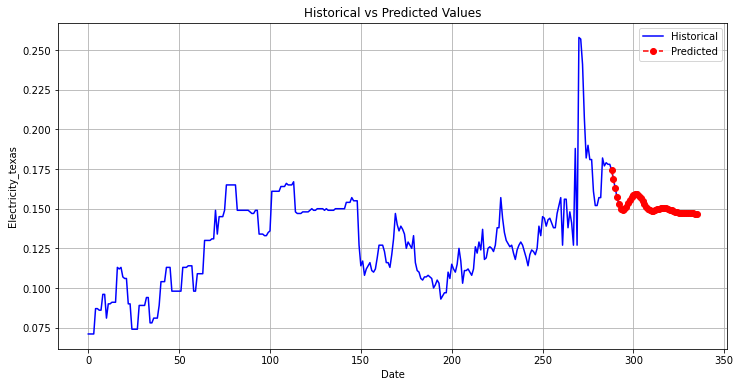

In [53]:
import matplotlib.pyplot as plt

# Extracting the historical data and dates
historical_dates = df.index.tolist()
historical_values = df[target_column].values.tolist()

# Plotting the historical and predicted values
plt.figure(figsize=(12, 6))
plt.plot(historical_dates, historical_values, label='Historical', color='blue')
plt.plot(historical_dates[-len(predicted_values_all):], predicted_values_all, label='Predicted', color='red', linestyle='--', marker='o')
plt.title('Historical vs Predicted Values')
plt.xlabel('Date')
plt.ylabel(target_column)
plt.legend()
plt.grid(True)
plt.show()
